# Genetic Variant Classifications
---

## Introduction

The ClinVar dataset is a public resource containing annotations about human genetic variants. These variants are (usually manually) classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic. Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting.

* Likely Benign or Benign
* VUS (uncertain significance)
* Likely Pathogenic or Pathogenic

## Question

Given a set of variant features, we are going to try and identify whether that variant is likely to posses a conflicting classification or not using machine learning as opposed to manual classification.

Conflicting classification has been assigned to a CLASS column. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.

## Models

The machine learning models I will be experiementing with to solve this problem are listed below:

* Logistic Regression
* Random Forest
* Gradient Boosting

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import EasyEnsemble
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2 as chi2_sk
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
%matplotlib inline

## Import the dataset

In [79]:
df = pd.read_csv('./data/clinvar_conflicting.csv')
df.shape

/Users/rook/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(65188, 46)

In [80]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


### Binary class split

In [81]:
df['CLASS'].value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

In [82]:
df['CLASS'].value_counts(normalize=True)

0    0.747898
1    0.252102
Name: CLASS, dtype: float64

Slightly imbalanced.

### Data preprocessing

In [83]:
X = df.loc[:, ~df.columns.isin(['CLASS'])]
Y = df['CLASS']

In [84]:
# Converting to categorical
convert_cat = []
to_drop = []
unique = None

categorical = X.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    unique = column.nunique()
    print(unique)
    
    cont = pd.crosstab(X[i], Y)
    chi2_res = scipy.stats.chi2_contingency(cont)
    
    # Keep all features with a significant P-value and drop the others
    if chi2_res[1] <= 0.05:
        convert_cat.append(i)
    else:
        to_drop.append(i)

CHROM
25
REF
866
ALT
458
CLNDISDB
9234
CLNDISDBINCL
48
CLNDN
9260
CLNDNINCL
54
CLNHGVS
65188
CLNSIGINCL
68
CLNVC
7
CLNVI
26289
MC
89
Allele
374
Consequence
48
IMPACT
4
SYMBOL
2328
Feature_type
2
Feature
2369
BIOTYPE
2
EXON
3264
INTRON
1929
cDNA_position
13970
CDS_position
13663
Protein_position
7339
Amino_acids
1262
Codons
2220
BAM_EDIT
2
SIFT
4
PolyPhen
4
MOTIF_NAME
2
HIGH_INF_POS
1


In [85]:
print(f'convert_cat\n------\n{convert_cat} \n')
print(f'to_drop\n------\n{to_drop}')

convert_cat
------
['CHROM', 'REF', 'ALT', 'CLNDISDB', 'CLNDN', 'CLNVC', 'MC', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Feature', 'EXON', 'INTRON', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'BAM_EDIT'] 

to_drop
------
['CLNDISDBINCL', 'CLNDNINCL', 'CLNHGVS', 'CLNSIGINCL', 'CLNVI', 'Feature_type', 'BIOTYPE', 'SIFT', 'PolyPhen', 'MOTIF_NAME', 'HIGH_INF_POS']


### Drop all features with more than 40% NaN's

In [86]:
to_drop_nans = []

for c in X.columns:
    if X[c].isnull().sum() / X.shape[0] > 0.40:
        print(f'{c}: {X[c].isnull().sum() / X.shape[0]}')
        to_drop_nans.append(c)
        
        # Remove from the convert_cat array
        if c in convert_cat:
            convert_cat.remove(c)
            
print(f'\nNumber of features to drop: {len(to_drop_nans)}')

CLNDISDBINCL: 0.9988341412529913
CLNDNINCL: 0.9988341412529913
CLNSIGINCL: 0.9988341412529913
CLNVI: 0.5757041173222065
SSR: 0.9984046143461986
INTRON: 0.8649598085537216
DISTANCE: 0.998343253359514
BAM_EDIT: 0.509587654169479
SIFT: 0.6190096336749095
PolyPhen: 0.6196232435417561
MOTIF_NAME: 0.9999693195066577
MOTIF_POS: 0.9999693195066577
HIGH_INF_POS: 0.9999693195066577
MOTIF_SCORE_CHANGE: 0.9999693195066577
BLOSUM62: 0.6073970669448365

Number of features to drop: 15


In [87]:
X = X.loc[:, ~X.columns.isin(to_drop_nans)]

There were a few features that were almost entirely made up of NaN values.  Instead of imputing this data and essentially creating 60,000+ rows of made up figures, I decided to drop them all together.

In [88]:
convert_cat

['CHROM',
 'REF',
 'ALT',
 'CLNDISDB',
 'CLNDN',
 'CLNVC',
 'MC',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Feature',
 'EXON',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons']

Above are the remaining categorical features to be converted to binary form.

### Convert features to categorical - get_dummies

In [89]:
# Deleting duplicate rows
X = X.loc[:,~X.columns.duplicated()]

# Drop cols with too many unique values
X = X.loc[:, ~X.columns.isin(to_drop)]

# Get dummies - conver to categroical
X = pd.get_dummies(data=X, columns=convert_cat)

X = X.loc[:,~X.columns.duplicated()]

In [90]:
X.shape

(65188, 66788)

In [91]:
# Find all features created by get_dummies
cat_feat = []

for feature in convert_cat:
    for col in X.loc[:, X.columns.str.startswith(feature + "_")].columns:
        cat_feat.append(col)

### Run Chi2 after get_dummies

In [92]:
gd_convert_cat = []
gd_to_dropt = []

for feature in cat_feat:
    cont = pd.crosstab(X[feature], Y)
    chi2_res = scipy.stats.chi2_contingency(cont)
    
    # Keep all features with a significant P-value and drop the others
    if chi2_res[1] <= 0.05:
        gd_convert_cat.append(feature)
    else:
        gd_to_dropt.append(feature)

In [93]:
len(gd_to_dropt)

64912

In [112]:
# Get all categoircal features again
# Find all features created by get_dummies
cat_feat = []

for feature in convert_cat:
    for col in X.loc[:, X.columns.str.startswith(feature + "_")].columns:
        cat_feat.append(col)

We can see that the results of the Chi2 test are show that we should drop a substntial number of dummy features.

In [94]:
X = X.loc[:, ~X.columns.isin(gd_to_dropt)]

In [95]:
X.shape

(65188, 1876)

Above we can see the number of remaining features by examining the shape of X.

### Finding all NaN rows

In [115]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

10940

There are still quite a few rows with NaN values.  We will have to impute the numerical features.

### Numerical Imputer

In [114]:
numerical_data = X.loc[:, ~X.columns.isin(X[cat_feat])]
print(numerical_data.columns)

Index(['POS', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'ORIGIN', 'STRAND', 'LoFtool',
       'CADD_PHRED', 'CADD_RAW'],
      dtype='object')


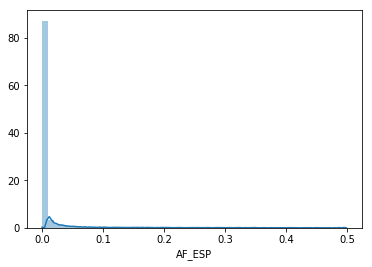

In [116]:
sns.distplot(X['AF_ESP'])

We can see that these numerical features are not normally distributed.  So we will use the median to impute the data. 

In [117]:
# For numerical data, impute using mean OR median values
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp = imp.fit(numerical_data)

# Impute our data
X[numerical_data.columns] = imp.transform(numerical_data)

In [118]:
nans = lambda X: X[X.isnull().any(axis=1)]
len(nans(X))

0

We can see that we no longer have any NaN values in our data.

We do not need to impute the categorical features because get_dummies does this for us.

### VarianceThreshold

In [119]:
# Removes all low-variance features
def variance_threshold_selector(data, threshold=0.05):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

vt_to_keep = variance_threshold_selector(X)

vt_to_keep.head()

,POS,ORIGIN,STRAND,LoFtool,CADD_PHRED,CADD_RAW,CHROM_1,CHROM_2,CHROM_5,CHROM_11,...,MC_SO:0001627|intron_variant,Allele_A,Allele_C,Allele_G,Allele_T,Consequence_missense_variant,IMPACT_HIGH,IMPACT_LOW,IMPACT_MODERATE,IMPACT_MODIFIER
0,955563.0,1.0,1.0,0.421,11.390,1.133255,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
1,955597.0,1.0,1.0,0.421,8.150,0.599088,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,955619.0,1.0,1.0,0.421,3.288,0.069819,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3,957640.0,1.0,1.0,0.421,12.560,1.356499,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,976059.0,1.0,1.0,0.421,17.740,2.234711,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [122]:
# X = X.loc[:, ~X.columns.isin(vt_to_drop)]
X = X[vt_to_keep.columns]

Variables with low variance really aren’t beneficial to our model.

### Display correlation Matrix to identify features that need to be dropped

In [124]:
correlation_matrix = X.corr()
display(correlation_matrix)

,POS,ORIGIN,STRAND,LoFtool,CADD_PHRED,CADD_RAW,CHROM_1,CHROM_2,CHROM_5,CHROM_11,...,MC_SO:0001627|intron_variant,Allele_A,Allele_C,Allele_G,Allele_T,Consequence_missense_variant,IMPACT_HIGH,IMPACT_LOW,IMPACT_MODERATE,IMPACT_MODIFIER
POS,1.000000,0.010341,-0.122584,0.258381,-0.004949,-0.008799,0.199746,0.403622,0.109581,-0.006367,...,-0.004403,0.000109,0.009060,-0.001598,0.003403,0.005505,-0.031125,0.021021,0.000822,-0.007929
ORIGIN,0.010341,1.000000,-0.009006,-0.021575,0.046219,0.052163,0.001611,-0.000724,-0.000823,-0.006612,...,-0.012429,0.005893,-0.008518,-0.004381,-0.002587,0.008358,0.044327,-0.028777,0.010887,-0.012201
STRAND,-0.122584,-0.009006,1.000000,-0.148790,0.014293,0.009340,-0.037417,-0.122106,0.117946,0.083352,...,-0.002026,-0.038894,-0.041034,0.076873,0.009328,-0.000550,-0.000787,0.002695,0.000314,-0.004366
LoFtool,0.258381,-0.021575,-0.148790,1.000000,-0.032411,-0.033348,-0.042282,0.186457,0.015560,0.121785,...,-0.018733,-0.029711,0.039009,0.017905,-0.013260,0.029406,-0.004316,-0.009589,0.026423,-0.027059
CADD_PHRED,-0.004949,0.046219,0.014293,-0.032411,1.000000,0.954832,0.013997,0.003979,-0.001933,0.043881,...,-0.289163,0.063055,-0.166418,-0.113621,0.139637,0.351695,0.376313,-0.447707,0.366433,-0.250787
CADD_RAW,-0.008799,0.052163,0.009340,-0.033348,0.954832,1.000000,0.013964,-0.004036,0.000534,0.047204,...,-0.243923,0.070973,-0.146230,-0.109007,0.115297,0.262472,0.470595,-0.422492,0.269884,-0.208329
CHROM_1,0.199746,0.001611,-0.037417,-0.042282,0.013997,0.013964,1.000000,-0.105889,-0.065886,-0.076743,...,0.015639,0.007160,-0.001187,-0.021083,0.012936,-0.005649,-0.007176,0.007269,-0.007203,0.007302
CHROM_2,0.403622,-0.000724,-0.122106,0.186457,0.003979,-0.004036,-0.105889,1.000000,-0.095132,-0.110809,...,-0.028737,-0.011292,0.014122,0.012929,-0.004231,0.038108,-0.020912,-0.015183,0.036511,-0.020248
CHROM_5,0.109581,-0.000823,0.117946,0.015560,-0.001933,0.000534,-0.065886,-0.095132,1.000000,-0.068947,...,-0.020896,-0.019389,-0.000967,0.042566,-0.015235,0.011463,0.004223,-0.000490,0.011217,-0.023139
CHROM_11,-0.006367,-0.006612,0.083352,0.121785,0.043881,0.047204,-0.076743,-0.110809,-0.068947,1.000000,...,-0.005134,-0.014104,0.000164,0.017053,-0.009525,-0.010358,0.059553,-0.020470,-0.008884,-0.005007


In [125]:
# Correlated features to be dropped
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Number of correlated features to drop: {len(to_drop)}')

Number of correlated features to drop: 7


In [126]:
cols = list(X.columns)

for col in to_drop: 
    cols.remove(col)

len(cols)

X = X[cols]

Here we are dropping highly correlated features.

In [127]:
# Save the DF for future reference
X.to_csv('./data/X_df_v2.csv')

## Train / Test splits

In [128]:
# Train splits
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.40, random_state=42, stratify=Y)

# Dev and Test splits
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

We are splitting the data into a train, test and dev set.

In [223]:
def plot_roc_curve(labels, probs):
    fpr, tpr, thresholds = roc_curve(labels, probs)

    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    # find threshold closest to zero
    close_zero = np.argmin(np.abs(thresholds)) 
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
                 label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)

## Logistic Regression

In [239]:
# Define the LR model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Train
lr_preds_train = lr.predict_proba(X_train)
lr_probs_train = lr_preds_train[:, 1]
lr_roc_train = roc_auc_score(y_train, lr_probs_train)

# Dev
lr_preds_dev = lr.predict_proba(X_dev)
lr_probs_dev = lr_preds_dev[:, 1]
lr_roc_dev = roc_auc_score(y_dev, lr_probs_dev)

print(f'roc_auc_score Train: {lr_roc_train}')
print(f'roc_auc_score Dev: {lr_roc_dev}\n')

probs_lr = np.argmax(lr_preds_dev, axis=1)
conf_matrix_lr_dev = confusion_matrix(y_dev, probs_lr)
print(f'Confusion Matrix:\n{conf_matrix_lr_dev}\n')

print(classification_report(y_dev, np.argmax(lr_preds_dev, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

roc_auc_score Train: 0.4988218485572249
roc_auc_score Dev: 0.49571504168427244

Confusion Matrix:
[[9751    0]
 [3287    0]]

                 precision    recall  f1-score   support

Non-Conflicting       0.75      1.00      0.86      9751
    Conflicting       0.00      0.00      0.00      3287

    avg / total       0.56      0.75      0.64     13038



/Users/rook/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


From these results, it would appear that this is a pretty useless model.

## Logistic Regression Grid Search

Best Parameters: {'C': 1.0, 'penalty': 'l2'}

roc_auc_score Train: 0.4988218485572249
roc_auc_score Dev: 0.49571504168427244

Confusion Matrix:
[[9751    0]
 [3287    0]] 

                 precision    recall  f1-score   support

Non-Conflicting       0.75      1.00      0.86      9751
    Conflicting       0.00      0.00      0.00      3287

    avg / total       0.56      0.75      0.64     13038



/Users/rook/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


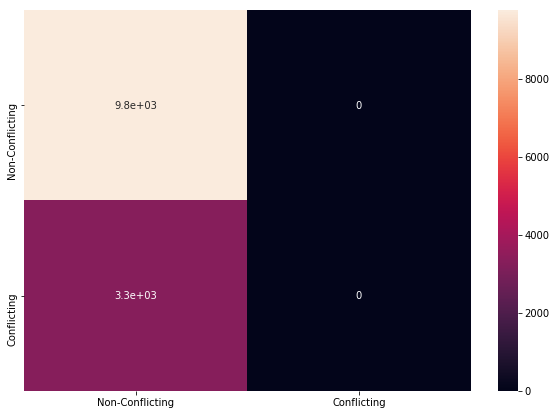

In [240]:
lr_gs = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

grid_log_r = GridSearchCV(lr_gs, param_grid=hyperparameters, refit='recall_score', cv=5, n_jobs=-1)
grid_log_r.fit(X_train, y_train)

# Train
lr_preds_train = lr.predict_proba(X_train)
lr_probs_train = lr_preds_train[:, 1]
lr_roc_train = roc_auc_score(y_train, lr_probs_train)

# Dev
lr_preds_dev = lr.predict_proba(X_dev)
lr_probs_dev = lr_preds_dev[:, 1]
lr_roc_dev = roc_auc_score(y_dev, lr_probs_dev)

# Confusion matrix
conf_matrix_lr_dev = confusion_matrix(y_dev, np.argmax(lr_preds_dev, axis=1))

# Best parameters from the grid search
best_params = grid_log_r.best_params_
print(f'Best Parameters: {best_params}\n')

print(f'roc_auc_score Train: {lr_roc_train}')
print(f'roc_auc_score Dev: {lr_roc_dev}\n')
print(f'Confusion Matrix:\n{conf_matrix_lr_dev} \n')

print(classification_report(y_dev, np.argmax(lr_preds_dev, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

# Classification report and heatmap
df_cm = pd.DataFrame(conf_matrix_lr_dev, index = [i for i in ['Non-Conflicting', 'Conflicting']],
                  columns = ['Non-Conflicting', 'Conflicting'])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)


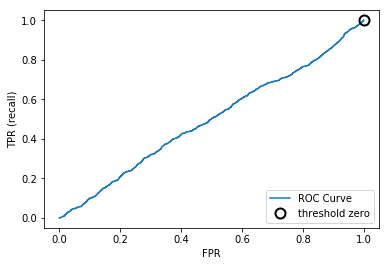

In [241]:
# Plot ROC curve
plot_roc_curve(y_dev, lr_probs_dev)

With this model, the AUC is roughly at chance level, meaning that the output is as good as random.

## Random Forest

In [253]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X_train, y_train)

# Train
rfc_preds_train = rfc.predict_proba(X_train)
rfc_probs_train = rfc_preds_train[:, 1]
rfc_roc_train = roc_auc_score(y_train, rfc_probs_train)

# Dev
rfc_preds_dev = rfc.predict_proba(X_dev)
rfc_probs_dev = rfc_preds_dev[:, 1]
rfc_roc_dev = roc_auc_score(y_dev, rfc_probs_dev)

# AUC Scores
print(f'roc_auc_score Train: {rfc_roc_train}')
print(f'roc_auc_score Dev: {rfc_roc_dev}\n')

# Confusion Matrix
# probs_rf = np.argmax(rfc_preds_dev, axis=1)
conf_matrix_rf_dev = confusion_matrix(y_dev, np.argmax(rfc_preds_dev, axis=1))
print(f'Confusion Matrix:\n{conf_matrix_rf_dev}\n')

# Classification Report
print(classification_report(y_dev, np.argmax(rfc_preds_dev, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

roc_auc_score Train: 1.0
roc_auc_score Dev: 0.6322950596721774

Confusion Matrix:
[[8854  897]
 [2700  587]]

                 precision    recall  f1-score   support

Non-Conflicting       0.77      0.91      0.83      9751
    Conflicting       0.40      0.18      0.25      3287

    avg / total       0.67      0.72      0.68     13038



## Random Forest Grid Search

Best Parameters: {'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}

roc_auc_score Train: 0.9412239110434085
roc_auc_score Dev: 0.653952523400048

Confusion Matrix: 
 [[9517  234]
 [3078  209]] 

                 precision    recall  f1-score   support

Non-Conflicting       0.76      0.98      0.85      9751
    Conflicting       0.47      0.06      0.11      3287

    avg / total       0.68      0.75      0.67     13038



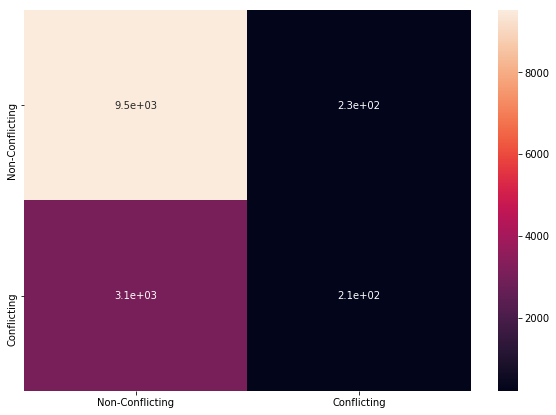

In [248]:
parameters = {'n_estimators':[100,300,500],
             'max_features':['sqrt', 'log2'],
             'min_samples_split':[2,8,20]
             }
# 'max_depth':[5,6,7,8]

# Instantiating and fitting Grid Search, then printing best score and best parameters
grid_rfc = GridSearchCV(rfc, param_grid=parameters, refit='recall_score', cv=5, n_jobs=2)
grid_rfc.fit(X_train, y_train)

# Train
rfc_preds_train = grid_rfc.predict_proba(X_train)
rfc_probs_train = rfc_preds_train[:, 1]
rfc_roc_train = roc_auc_score(y_train, rfc_probs_train)

# Dev
rfc_preds_dev = grid_rfc.predict_proba(X_dev)
rfc_probs_dev = rfc_preds_dev[:, 1]
rfc_roc_dev = roc_auc_score(y_dev, rfc_probs_dev)

# Confusion matrix
conf_matrix_rf_dev = confusion_matrix(y_dev, np.argmax(rfc_preds_dev, axis=1))

# Best parameters from the grid search
best_params = grid_rfc.best_params_
print(f'Best Parameters: {best_params}\n')

print(f'roc_auc_score Train: {rfc_roc_train}')
print(f'roc_auc_score Dev: {rfc_roc_dev}\n')
print(f'Confusion Matrix: \n {conf_matrix_rf_dev} \n')
print(classification_report(y_dev, np.argmax(rfc_preds_dev, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

# Classification report and heatmap
df_cm = pd.DataFrame(conf_matrix_rf_dev, index = [i for i in ['Non-Conflicting', 'Conflicting']],
                  columns = ['Non-Conflicting', 'Conflicting'])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

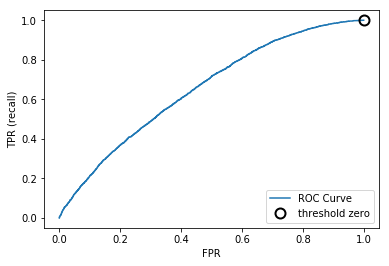

In [249]:
# Plot ROC curve
plot_roc_curve(y_dev, rfc_probs_dev)

The Random Forest model performs better than logistic regression.

## Gradient Boosting

In [250]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 700,
          'max_depth': 3,
          'loss': 'deviance'}

# Initialize and fit the model.
gb_clf = ensemble.GradientBoostingClassifier(**params)
gb_clf.fit(X_train, y_train)

# Train
gb_preds_train = gb_clf.predict_proba(X_train)
gb_probs_train = gb_preds_train[:, 1]
gb_roc_train = roc_auc_score(y_train, gb_probs_train)

# Dev
gb_preds_dev = gb_clf.predict_proba(X_dev)
gb_probs_dev = gb_preds_dev[:, 1]
gb_roc_dev = roc_auc_score(y_dev, gb_probs_dev)

# AUC Scores
print(f'roc_auc_score Train: {gb_roc_train}')
print(f'roc_auc_score Dev: {gb_roc_dev}\n')

# Confusion Matrix
probs_gb = np.argmax(gb_preds_dev, axis=1)
conf_matrix_gb_dev = confusion_matrix(y_dev, probs_gb)
print(f'Confusion Matrix: \n {conf_matrix_gb_dev}\n')

# Classification Report
print(classification_report(y_dev, probs_gb, target_names=['Non-Conflicting', 'Conflicting']))

roc_auc_score Train: 0.7514867050924068
roc_auc_score Dev: 0.6690795826733675

Confusion Matrix: 
 [[9610  141]
 [3139  148]]

                 precision    recall  f1-score   support

Non-Conflicting       0.75      0.99      0.85      9751
    Conflicting       0.51      0.05      0.08      3287

    avg / total       0.69      0.75      0.66     13038



Gradient Boosting seems to perform slightly better than the Random Forest model

## Gradient Boosting Grid Search

Best Parameters: {'loss': 'exponential', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}

roc_auc_score Train: 0.7563508114006317
roc_auc_score Dev: 0.6559383408040619

Confusion Matrix: 
 [[9686   65]
 [3216   71]] 

                 precision    recall  f1-score   support

Non-Conflicting       0.75      0.99      0.86      9751
    Conflicting       0.52      0.02      0.04      3287

    avg / total       0.69      0.75      0.65     13038



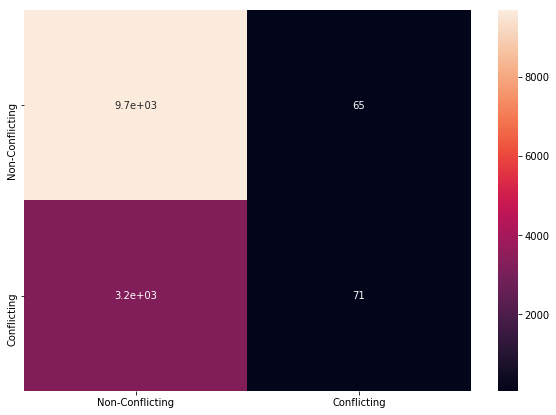

In [251]:
parameters = {'loss':['deviance', 'exponential'],
              'min_samples_split':[2, 5, 10],
              'max_depth':[5,6,7,8],
              'max_features':['sqrt', 'log2'],
              'n_estimators':[100,300,600]}

#fitting model and printing best parameters and score from model
grid_gb = GridSearchCV(gb_clf, param_grid=parameters, refit='recall_score', n_jobs=2)
grid_gb.fit(X_train, y_train)


# Train
gb_preds_train = grid_gb.predict_proba(X_train)
gb_probs_train = gb_preds_train[:, 1]
gb_roc_train = roc_auc_score(y_train, gb_probs_train)

# Dev
gb_preds_dev = grid_gb.predict_proba(X_dev)
gb_probs_dev = gb_preds_dev[:, 1]
gb_roc_dev = roc_auc_score(y_dev, gb_probs_dev)

# Confusion matrix
conf_matrix_gb_dev = confusion_matrix(y_dev, np.argmax(gb_preds_dev, axis=1))

# Best parameters from the grid search
best_params = grid_gb.best_params_
print(f'Best Parameters: {best_params}\n')

print(f'roc_auc_score Train: {gb_roc_train}')
print(f'roc_auc_score Dev: {gb_roc_dev}\n')
print(f'Confusion Matrix: \n {conf_matrix_gb_dev} \n')
print(classification_report(y_dev, np.argmax(gb_preds_dev, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

# Classification report and heatmap
df_cm = pd.DataFrame(conf_matrix_gb_dev, index = [i for i in ['Non-Conflicting', 'Conflicting']],
                  columns = ['Non-Conflicting', 'Conflicting'])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

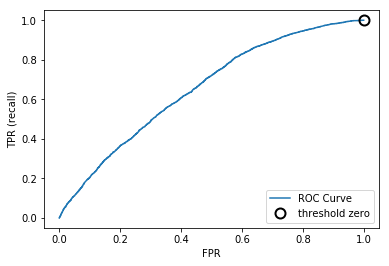

In [252]:
# Plot ROC curve
plot_roc_curve(y_dev, gb_probs_dev)

Gradient Boosting is the most accurate models and seems to be much better in regards generalization.

## Conclusion

While achieving an accuracy level of 78% using Gradient Boosting is not immediately impressive, I think applying machine learning to the field of genomics is a step in the right direction.  While I have no domain knowledge in this specific area, I imagine it would be beneficial to be able to predict with 78% accuracy, whether or not a genetic variation will result in conflicting classifications.  Given this additional knowledge, labs or clinicians could add additional levels of inspection to overcome the increased likelihood of a conflicting classification.

## Challenges I faced

The most challenging aspect of this problem was preprocessing the data.  

* There were quite a few categorical variables that needed to be converted to a binary form.  

* Some of the categorical variables also consisted of thousands of unique values.  

* Every row consisted of NaN values, which meant imputing the data was a necessity.

* I had no domain knowledge in the area, so feature engineering was not an option, which likely hindered my ability to improve the accuracy of my models

In [255]:
rfc_2 = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc_2.fit(X_train, y_train)

# Train
rfc_preds_train_2 = rfc_2.predict_proba(X_train)
rfc_probs_train_2 = rfc_preds_train_2[:, 1]
rfc_roc_train_2 = roc_auc_score(y_train, rfc_probs_train_2)

# Dev
rfc_preds_dev_2 = rfc_2.predict_proba(X_dev)
rfc_probs_dev_2 = rfc_preds_dev_2[:, 1]
rfc_roc_dev_2 = roc_auc_score(y_dev, rfc_probs_dev_2)

# Dev
rfc_preds_test_2 = rfc_2.predict_proba(X_test)
rfc_probs_test_2 = rfc_preds_test_2[:, 1]
rfc_roc_test_2 = roc_auc_score(y_test, rfc_probs_test_2)

# AUC Scores
print(f'roc_auc_score Train: {rfc_roc_train_2}')
print(f'roc_auc_score Dev: {rfc_roc_dev_2}\n')
print(f'roc_auc_score Test: {rfc_roc_test_2}\n')

# Confusion Matrix
# probs_rf = np.argmax(rfc_preds_dev, axis=1)
conf_matrix_rf_dev_2 = confusion_matrix(y_dev, np.argmax(rfc_preds_dev_2, axis=1))
print(f'Confusion Matrix:\n{conf_matrix_rf_dev_2}\n')

# Classification Report
print(classification_report(y_dev, np.argmax(rfc_preds_dev_2, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

print('\n')

conf_matrix_rf_test_2 = confusion_matrix(y_test, np.argmax(rfc_preds_test_2, axis=1))
print(f'Confusion Matrix:\n{conf_matrix_rf_test_2}\n')

# Classification Report
print(classification_report(y_test, np.argmax(rfc_preds_test_2, axis=1), target_names=['Non-Conflicting', 'Conflicting']))

roc_auc_score Train: 1.0
roc_auc_score Dev: 0.6342014581079216

roc_auc_score Test: 0.625051959286695

Confusion Matrix:
[[8852  899]
 [2699  588]]

                 precision    recall  f1-score   support

Non-Conflicting       0.77      0.91      0.83      9751
    Conflicting       0.40      0.18      0.25      3287

    avg / total       0.67      0.72      0.68     13038



Confusion Matrix:
[[8889  862]
 [2705  582]]

                 precision    recall  f1-score   support

Non-Conflicting       0.77      0.91      0.83      9751
    Conflicting       0.40      0.18      0.25      3287

    avg / total       0.68      0.73      0.68     13038



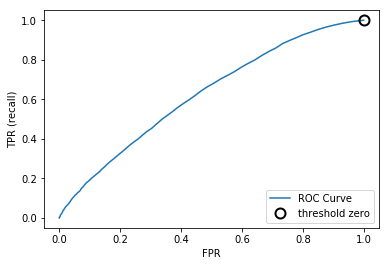

In [256]:
# Plot ROC curve
plot_roc_curve(y_test, rfc_probs_test_2)